## Import packages

In [3]:
import pandas as pd
import numpy as np

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import classification_report

## Data

In [ ]:
X_train = pd.read_csv('../datasets/word2vec/train_data_imputed_FINAL.csv')
X_test = pd.read_csv('../datasets/word2vec/test_data_imputed_FINAL.csv')
y_train = pd.read_csv('../datasets/word2vec/y_train_FINAL.csv').iloc[:,1:]
y_test = pd.read_csv('../datasets/word2vec/y_test_FINAL.csv').iloc[:,1:]

In [ ]:
print('X_train: ' + str(X_train.shape))
print('y_train: ' + str(y_train.shape))
print('X_test: ' + str(X_test.shape))
print('y_test: ' + str(y_test.shape))

X_train: (11516, 263)
y_train: (11516, 1)
X_test: (2880, 263)
y_test: (2880, 1)


In [ ]:
X_train.head()

,location_AE,location_AM,location_AR,location_AT,location_AU,location_BD,location_BE,location_BG,location_BH,location_BR,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.415787,0.115367,-0.607734,-0.417199,0.090155,-0.399479,0.503071,0.088093,0.643417,0.180743
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.063942,-0.109937,-0.384977,-0.260925,-0.078151,-0.189497,0.363736,0.123283,0.343995,0.145450
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.309970,0.085213,-0.189873,-0.619696,0.238990,-0.288888,0.493239,0.069656,0.187424,0.184120
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.368265,-0.251463,-0.302825,0.120311,0.266548,-0.580960,0.567253,0.167470,0.057360,0.911378
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.103269,-0.057475,-0.195160,-0.509560,0.362500,0.138404,-0.018908,0.024695,0.141623,-0.178447


In [ ]:
y_train.head()

,fraudulent
17870,0
1980,0
15464,0
7493,0
16719,0


## Oversampling

In [ ]:
def SMOTE_ENN(X_train, y_train, n_neighbours, k_neighbours, sampling_strategy):
    # SMOTE ENN oversampling
    smote_only = SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors = k_neighbours)
    ennObj = EditedNearestNeighbours(n_neighbors=n_neighbours)
    smote_enn = SMOTEENN(random_state=42, smote=smote_only , enn= ennObj)
    X_res_smoteENN, y_res_smoteENN = smote_enn.fit_resample(X_train, y_train)
    return X_res_smoteENN, y_res_smoteENN

X_train_smenn, y_train_smenn = SMOTE_ENN(X_train, y_train, n_neighbours = 4, k_neighbours = 6, sampling_strategy = 0.1)

In [ ]:
original_counter = Counter(y_train.loc[:,'fraudulent'])
print("Before count", original_counter)

Before count Counter({0: 11293, 1: 223})


In [ ]:
after_counter = Counter(y_train_smenn.loc[:,'fraudulent'])
print("After count", after_counter)

After count Counter({0: 10968, 1: 1129})


## XGBoost

In [ ]:
# helper function

def evaluate(model):
  y_pred = model.predict(X_test)

  print ('\nAccuracy Score :',accuracy_score(y_test, y_pred))
  print ('Precision score :',precision_score(y_test, y_pred))
  print ('Recall_score :',recall_score(y_test, y_pred))
  print ('F1 score :',f1_score(y_test, y_pred))
  print ('ROC score :',roc_auc_score(y_test, y_pred))

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()
  plt.show()

### Default XGBoost


Accuracy Score : 0.9857638888888889
Precision score : 0.7586206896551724
Recall_score : 0.39285714285714285
F1 score : 0.5176470588235293
ROC score : 0.6951891946580332


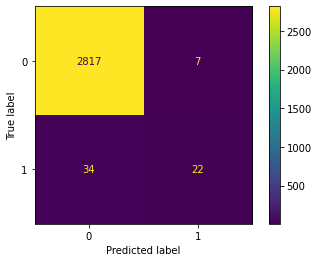

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_smenn, y_train_smenn['fraudulent'])

evaluate(xgb)

### Hyperparameter Tuning

In [ ]:
params = {
    'learning_rate':[0.05, 0.1, 0.3],
    'subsample':[0.7, 0.8, 1], 
    'colsample_bytree':[0.7, 0.8, 1],
    'max_depth': [50, 100, 200, 300]
}

In [ ]:
xgb_estimator = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = xgb_estimator, param_distributions = params, cv = 5, verbose=2, random_state=2022, n_jobs = -1, scoring='f1', refit=True)
xgb_random.fit(X_train_smenn, y_train_smenn['fraudulent'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1],
                                        'learning_rate': [0.05, 0.1, 0.3],
                                        'max_depth': [50, 100, 200, 300],
                                        'subsample': [0.7, 0.8, 1]},
                   random_state=2022, scoring='f1', verbose=2)

In [ ]:
# Best Params
xgb_random.best_params_

{'subsample': 0.8,
 'max_depth': 100,
 'learning_rate': 0.3,
 'colsample_bytree': 0.8}


Accuracy Score : 0.990625
Precision score : 0.9142857142857143
Recall_score : 0.5714285714285714
F1 score : 0.7032967032967032
ROC score : 0.7851831242411978


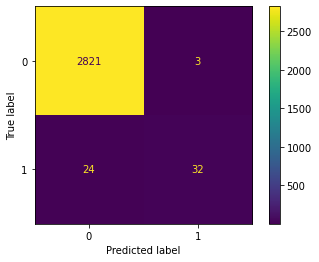

In [ ]:
# Best Model
tuned_xgb = xgb_random.best_estimator_
evaluate(tuned_xgb)